In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pyplot import subplots
import os

## 1 - Data

### 1.1 Data Loading

In [115]:
stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)
stk_data['PRC'] = abs(stk_data['PRC'])
stk_data['MktCap_Mon'] = stk_data['PRC']*stk_data['SHROUT'] 
stk_data['date'] = pd.to_datetime(stk_data['date'], format='%Y-%m-%d')
stk_data['Year'] = stk_data['date'].dt.strftime('%Y')
stk_data['date'] = stk_data['date'].dt.strftime('%Y-%m')
stk_data

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_6834/1407839232.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year
0,10001,1990-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.93750,-0.018519,1022.0,-0.070114,1.015612e+04,1990
1,10001,1990-02,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,-0.006289,1022.0,0.014900,1.009225e+04,1990
2,10001,1990-03,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.012658,1027.0,0.024148,1.014162e+04,1990
3,10001,1990-04,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.000000,1027.0,-0.028283,1.014162e+04,1990
4,10001,1990-05,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.75000,-0.012658,1027.0,0.088935,1.001325e+04,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
3150178,93436,2023-08,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023
3150179,93436,2023-09,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023
3150180,93436,2023-10,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023
3150181,93436,2023-11,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023


In [47]:
FF_data = pd.read_csv("Data/F&F_Factors.csv")
FF_data.index = FF_data['dateff']
FF_data = FF_data.drop("dateff", axis=1)
FF_data.index = pd.to_datetime(FF_data.index, format="%Y-%m-%d").to_period('M')
FF_data.rename_axis('date', inplace=True)

In [74]:
Acc_Data = pd.read_csv("Data/Acc_Data2.csv", header=0)
Acc_Data = Acc_Data.rename(columns={'LPERMNO': 'PERMNO'})
Acc_Data = Acc_Data.rename(columns={'datadate': 'date'})
Acc_Data.drop_duplicates(subset=['PERMNO', 'date'], inplace=True, ignore_index=True)
Acc_Data['date'] = pd.to_datetime(Acc_Data['date'])
Acc_Data['date'] = Acc_Data['date'].dt.year
Acc_Data.sort_values(by=['PERMNO','date'])

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt
86969,12994,1987,INDL,C,D,STD,USD,5.4178,2.750,NaN,0.32,5.369,I,LC,10001,1987-06-30
86970,12994,1988,INDL,C,D,STD,USD,5.5565,2.555,NaN,0.57,5.512,I,LC,10001,1988-06-30
86971,12994,1989,INDL,C,D,STD,USD,6.3147,7.370,NaN,1.21,6.321,I,LC,10001,1989-06-30
86972,12994,1990,INDL,C,D,STD,USD,6.9631,7.175,NaN,1.10,7.179,I,LC,10001,1990-06-29
86973,12994,1991,INDL,C,D,STD,USD,7.4390,6.965,NaN,1.01,7.982,I,LC,10001,1991-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230345,184996,2019,INDL,C,D,STD,USD,36.5635,12627.000,14697.0,-4.92,6618.000,A,LC,93436,2019-12-31
230346,184996,2020,INDL,C,D,STD,USD,23.1510,10888.000,13347.0,0.64,22225.000,A,LC,93436,2020-12-31
230347,184996,2021,INDL,C,D,STD,USD,29.2246,6916.000,8873.0,4.90,30189.000,A,LC,93436,2021-12-31
230348,184996,2022,INDL,C,D,STD,USD,14.1290,3761.000,5748.0,3.62,44704.000,A,LC,93436,2022-12-30


# 2 - Strategies Evaluation

## 2.1 Quality Strategy

### 2.1.1 Defining Quality Score

In [76]:
Acc_Data['ROE'] = Acc_Data['epsfi']/Acc_Data['bkvlps']
Acc_Data['DtE_Rat'] = Acc_Data['dltt']/Acc_Data['seq']
Acc_Data

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
0,1001,1985,INDL,C,D,STD,USD,3.2633,11.908,NaN,0.68,13.014,I,LU,10015,1985-12-31,0.208378,0.915015
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236390,347085,2023,INDL,C,D,STD,USD,4.6842,5.786,9.844,1.05,144.982,A,LC,21069,2023-02-28,0.224158,0.039908
236391,348615,2023,INDL,C,D,STD,USD,2.9612,4.795,11.642,-0.48,97.590,A,LC,23424,2023-12-29,-0.162096,0.049134
236392,348892,2022,INDL,C,D,STD,USD,0.5382,3.109,3.503,-2.26,7.883,A,LC,20846,2022-12-30,-4.199182,0.394393
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000


In [77]:
Quality_df = Acc_Data
company_years = Quality_df.groupby('PERMNO')['date'].nunique()
companies_with_5_years = company_years[company_years >= 5].index
companies_with_5_years

Acc_data_filtered = Acc_Data[Acc_Data['PERMNO'].isin(companies_with_5_years)]
Acc_data_filtered

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082
5,1003,1990,INDL,C,D,STD,USD,-0.1551,0.076,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,-0.182692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236372,332115,2022,INDL,C,D,STD,USD,0.9982,31.804,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,0.881486
236388,347007,2022,INDL,C,D,STD,USD,-1.0611,289.286,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-0.646699
236389,347007,2023,INDL,C,D,STD,USD,-0.8750,876.894,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.493890
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000


In [78]:
def calculate_evar(group):
    if len(group) > 4:
        group['EPSg'] = group['epsfi'].pct_change() * 100
        group.loc[4:, 'EVAR'] = group['EPSg'].rolling(window=4).std(ddof=1)
        
    else:
        group['EVAR'] = 0
        
    return group

In [79]:
Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)
Acc_data_filtered

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_6834/3759281452.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)


,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat,EPSg,EVAR
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476,NaN,NaN
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816,233.333333,NaN
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734,-76.666667,NaN
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082,-4271.428571,NaN
5,1003,1990,INDL,C,D,STD,USD,-0.1551,0.076,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,-0.182692,-97.260274,2150.937866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236372,332115,2022,INDL,C,D,STD,USD,0.9982,31.804,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,0.881486,12.500000,77.771864
236388,347007,2022,INDL,C,D,STD,USD,-1.0611,289.286,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-0.646699,16.853933,30.756963
236389,347007,2023,INDL,C,D,STD,USD,-0.8750,876.894,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.493890,10.576923,31.164466
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000,-57.598039,109.489869


In [80]:
def Q_score(df):
    mean_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].mean()
    std_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].std()

    df = df.merge(mean_per_year, on='date', suffixes=('', '_mean'))
    df = df.merge(std_per_year, on='date', suffixes=('', '_std'))

    df['ROE Z-Score'] = (df['ROE'] - df['ROE_mean']) / df['ROE_std']
    df['DtE_Rat Z-Score'] = (df['DtE_Rat'] - df['DtE_Rat_mean']) / df['DtE_Rat_std']
    df['Evar Z-Score'] = (df['EVAR'] - df['EVAR_mean']) / df['EVAR_std']

    df['Quality Z-Score'] = df[['ROE Z-Score', 'DtE_Rat Z-Score', 'Evar Z-Score']].mean(axis=1)
    
    conditions = [
        (df['ROE'].isnull()), # If ROE is missing
        (df['DtE_Rat'].isnull()) | (df['EVAR'].isnull()), # If DtE_Rat or EVAR is missing
        (df[['ROE', 'DtE_Rat', 'EVAR']].isnull().sum(axis=1) >= 2) # If more than 2 values are missing
    ]
    choices = [
        np.nan, # If ROE is missing
        (df['ROE Z-Score'] + df['Evar Z-Score']) / 2, # If DtE_Rat or EVAR is missing
        np.nan # If more than 2 values are missing
    ]
    df['Quality Z-Score'] = np.select(conditions, choices, default=df['Quality Z-Score'])

    df['Quality Score'] = df['Quality Z-Score'].apply(lambda x: (1 + x) if x >= 0 else (1 - x)**(-1) if not np.isnan(x) else np.nan)
    
    return df

In [81]:
Quality_df = Acc_data_filtered
Quality_df = Q_score(Quality_df)
Quality_df['date'] = pd.to_datetime(Quality_df['date'], format= "%Y")
Quality_df['date'] = Quality_df['date'].dt.strftime('%Y')
Quality_df = Quality_df[['date', 'PERMNO', 'Quality Score']]
Quality_df.rename(columns={'date': 'Year'}, inplace=True)
Quality_df

,Year,PERMNO,Quality Score
0,1986,10031,NaN
1,1986,54594,NaN
2,1986,10066,NaN
3,1986,10074,NaN
4,1986,10082,NaN
...,...,...,...
215501,2023,15920,0.917093
215502,2023,17676,0.980181
215503,2023,18144,0.932924
215504,2023,14615,0.898050


Now, we are going to merge the 2 datasets:

* Monthly stock returns (with montly market cap): "stk_data"
* Yearly deciles sorting: "Quality_df"

In [82]:
merged_df = pd.merge(stk_data, Quality_df, on=['Year', 'PERMNO'], how='left')
merged_df.dropna(subset=['Quality Score'], inplace=True)
merged_df.drop(columns=['Year'], inplace=True)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Quality Score
12,10001,1991-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.62500,0.013158,1054.0,0.049083,1.014475e+04,0.912553
13,10001,1991-02,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.75000,0.012987,1054.0,0.075848,1.027650e+04,0.912553
14,10001,1991-03,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.50000,-0.011538,1054.0,0.028922,1.001300e+04,0.912553
15,10001,1991-04,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.039474,1054.0,0.003311,1.040825e+04,0.912553
16,10001,1991-05,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.000000,1054.0,0.040737,1.040825e+04,0.912553
...,...,...,...,...,...,...,...,...,...,...,...,...
3154219,93436,2023-08,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,0.979029
3154220,93436,2023-09,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,0.979029
3154221,93436,2023-10,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,0.979029
3154222,93436,2023-11,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,0.979029


Now we perform the basic data cleaning suggested by Prof. Smajlbegovic in the weekly assignment n.2.
* Selecting only common stocks
* Selecting only stocks listed on the NYSE, NASDAQ or AMEX
* Selecting only non financial firms

**Note:** observations that do not have returns data are removed from the dataset.

In [83]:
merged_df = merged_df[(merged_df['SHRCD'] == 10) | (merged_df['SHRCD'] == 11)] # Selecting only common stock
merged_df = merged_df[(merged_df['EXCHCD'] == 1) | (merged_df['EXCHCD'] == 2) | (merged_df['EXCHCD'] == 3)] # Selecting only stocks listed on the NYSE, NASDAQ, or AMEX
merged_df['SICCD'] = pd.to_numeric(merged_df['SICCD'], errors='coerce')  
merged_df = merged_df[(merged_df['SICCD'] < 6000) | (merged_df['SICCD'] > 6999)]  # Removing financial firms stocks

In [84]:
merged_df['RET'] = pd.to_numeric(merged_df['RET'], errors='coerce')
merged_df = merged_df.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%Y-%m-%d')

In [85]:
def preprocess_dataframe(df):
    df = df[(df['SHRCD'] == 10) | (df['SHRCD'] == 11)] # Selecting only common stock
    df = df[(df['EXCHCD'] == 1) | (df['EXCHCD'] == 2) | (df['EXCHCD'] == 3)] # Selecting only stocks listed on the NYSE, NASDAQ, or AMEX
    df['SICCD'] = pd.to_numeric(df['SICCD'], errors='coerce')  
    #df = df[(df['SICCD'] < 6000) | (df['SICCD'] > 6999)]  # Removing financial firms stocks
    
    df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
    df = df.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    return df

In [86]:
merged_df = preprocess_dataframe(merged_df)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Quality Score
12,10001,1991-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.62500,0.013158,1054.0,0.049083,1.014475e+04,0.912553
13,10001,1991-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.75000,0.012987,1054.0,0.075848,1.027650e+04,0.912553
14,10001,1991-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.50000,-0.011538,1054.0,0.028922,1.001300e+04,0.912553
15,10001,1991-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.039474,1054.0,0.003311,1.040825e+04,0.912553
16,10001,1991-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.000000,1054.0,0.040737,1.040825e+04,0.912553
...,...,...,...,...,...,...,...,...,...,...,...,...
3154219,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,0.979029
3154220,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,0.979029
3154221,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,0.979029
3154222,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,0.979029


### 2.1.4 Deciles Portfolios Sorting

In [87]:
merged_df = merged_df.sort_values(by='Quality Score', ascending=False)
merged_df.dropna(subset=['Quality Score'], inplace=True)
merged_df['decile_Q'] = merged_df.groupby(['date'])['Quality Score'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Quality Score,decile_Q
1877456,80039,1999-02-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,26.4375,-0.057906,18384.0,-0.038083,486027.000,43.836353,10
1877455,80039,1999-01-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,28.0625,0.036952,18384.0,0.038447,515901.000,43.836353,10
1877457,80039,1999-03-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,27.6250,0.044917,18384.0,0.037925,507858.000,43.836353,10
1877458,80039,1999-04-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,29.8750,0.081448,18463.0,0.049092,551582.125,43.836353,10
1877459,80039,1999-05-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,29.0000,-0.029289,18463.0,-0.020708,535427.000,43.836353,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445361,76166,2004-05-01,11.0,3.0,2830.0,IMMUNE RESPONSE CORP,1.4400,-0.105590,48159.0,0.014068,69348.960,0.039551,1
1445363,76166,2004-07-01,11.0,3.0,2830.0,IMMUNE RESPONSE CORP,0.9500,-0.221312,48451.0,-0.037698,46028.450,0.039551,1
1445364,76166,2004-08-01,11.0,3.0,2830.0,IMMUNE RESPONSE CORP,0.7900,-0.168421,48451.0,0.002703,38276.290,0.039551,1
1445362,76166,2004-06-01,11.0,3.0,2830.0,IMMUNE RESPONSE CORP,1.2200,-0.152778,48370.0,0.021611,59011.400,0.039551,1


### 2.1.3 Deciles Portfolios Returns

In [88]:
def compute_deciles_port(merged_df):
    copy = merged_df.copy()
    
    grouped = copy.groupby(['date', 'decile_Q'])

    copy['Total_MktCap_Month_Decile'] = grouped['MktCap_Mon'].transform('sum')
    copy['Weight_Decile'] = copy['MktCap_Mon'] / copy['Total_MktCap_Month_Decile']
    copy['Weighted_RET_Decile'] = copy['RET'] * copy['Weight_Decile']


    portfolio_df = pd.pivot_table(copy, values='Weighted_RET_Decile', index='date', columns='decile_Q', aggfunc='sum')
    portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
    return portfolio_df

In [89]:
portfolio_df = compute_deciles_port(merged_df)
portfolio_df['H-L'] = portfolio_df['P10'] - portfolio_df['P1']
portfolio_df.index = pd.to_datetime(portfolio_df.index, format="%Y-%m-%d").to_period('M')
portfolio_df

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
1990-01,-0.053279,-0.056957,-0.064265,-0.060143,-0.065824,-0.046522,-0.061508,-0.077182,-0.048495,-0.091607,-0.038328
1990-02,0.003003,0.013152,0.011913,0.017908,0.041118,0.014310,0.044857,0.069855,0.022426,0.021209,0.018206
1990-03,0.028661,0.040634,0.028565,0.031565,0.031619,0.038605,0.018583,0.036051,0.018057,0.054652,0.025990
1990-04,-0.031154,-0.012468,-0.004386,-0.036278,-0.023440,-0.022506,-0.023236,-0.037174,-0.027807,-0.039451,-0.008297
1990-05,0.094494,0.101416,0.084414,0.088363,0.104601,0.127520,0.072662,0.078893,0.081649,0.083240,-0.011254
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.002683,-0.017264,-0.005099,0.012027,-0.023336,-0.023220,-0.021510,-0.022755,0.013021,0.005347,0.008030
2023-09,-0.049177,-0.042984,-0.059714,-0.043061,-0.060819,-0.058793,-0.019108,-0.033613,-0.056459,-0.061174,-0.011997
2023-10,-0.028817,0.023081,-0.034733,-0.023300,-0.007639,-0.020776,-0.044544,-0.092871,-0.000424,-0.029955,-0.001137


### 2.1.5 Returns Analysis

After forming the portfolios, we first compute excess returns (by subtracting the rf column of the FF data) and then merge the two dataframes in a single one.

In [90]:
rf = FF_data['rf']
portfolio_df = portfolio_df.sub(rf, axis=0)
portfolio_df

Quality_FF = pd.concat([portfolio_df, FF_data], axis=1)
Quality_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.058979,-0.062657,-0.069965,-0.065843,-0.071524,-0.052222,-0.067208,-0.082882,-0.054195,-0.097307,-0.044028,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,-0.002697,0.007452,0.006213,0.012208,0.035418,0.008610,0.039157,0.064155,0.016726,0.015509,0.012506,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.022261,0.034234,0.022165,0.025165,0.025219,0.032205,0.012183,0.029651,0.011657,0.048252,0.019590,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.038054,-0.019368,-0.011286,-0.043178,-0.030340,-0.029406,-0.030136,-0.044074,-0.034707,-0.046351,-0.015197,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.087694,0.094616,0.077614,0.081563,0.097801,0.120720,0.065862,0.072093,0.074849,0.076440,-0.018054,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.007183,-0.021764,-0.009599,0.007527,-0.027836,-0.027720,-0.026010,-0.027255,0.008521,0.000847,0.003530,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.053477,-0.047284,-0.064014,-0.047361,-0.065119,-0.063093,-0.023408,-0.037913,-0.060759,-0.065474,-0.016297,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.033517,0.018381,-0.039433,-0.028000,-0.012339,-0.025476,-0.049244,-0.097571,-0.005124,-0.034655,-0.005837,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


Plotting the cumulative returns of long-short quality factor vs. market benchmark:

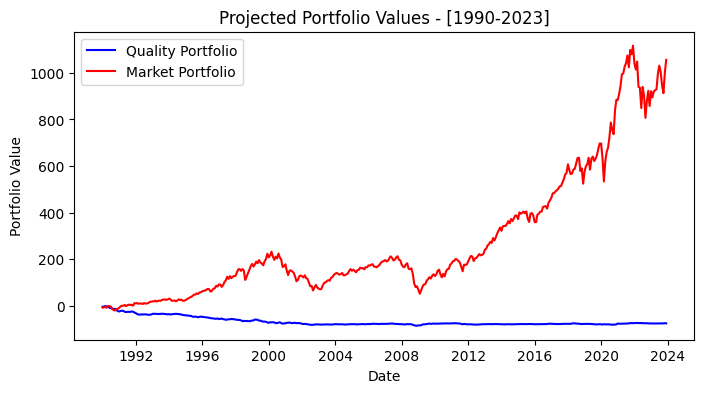

In [138]:
cumulative_returns1 = (1 + Quality_FF['H-L']).cumprod() 
cumulative_returns2 = (1 + Quality_FF['mktrf']).cumprod() 

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [1990-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

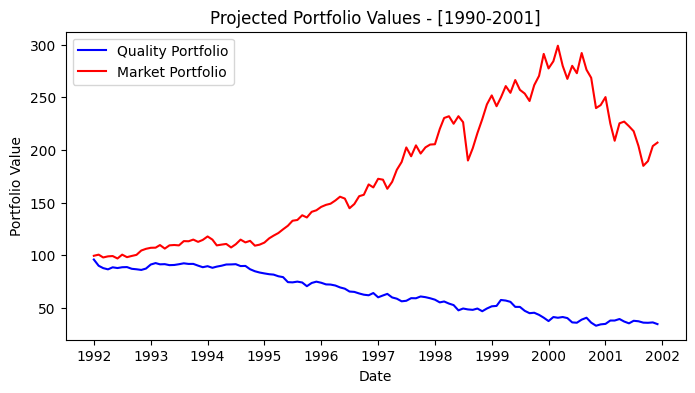

In [92]:
cumulative_returns1 = (1 + Quality_FF['H-L']['1992':'2001']).cumprod()
cumulative_returns2 = (1 + Quality_FF['mktrf']['1992':'2001']).cumprod()

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [1990-2001]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

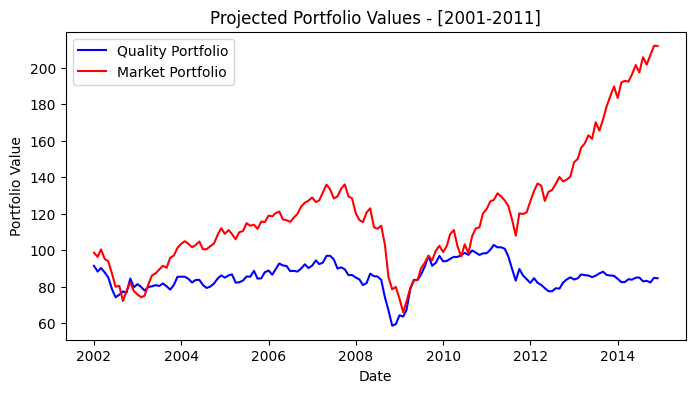

In [93]:
cumulative_returns1 = (1 + Quality_FF['H-L']['2002':'2014']).cumprod()
cumulative_returns2 = (1 + Quality_FF['mktrf']['2002':'2014']).cumprod()

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [2001-2011]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

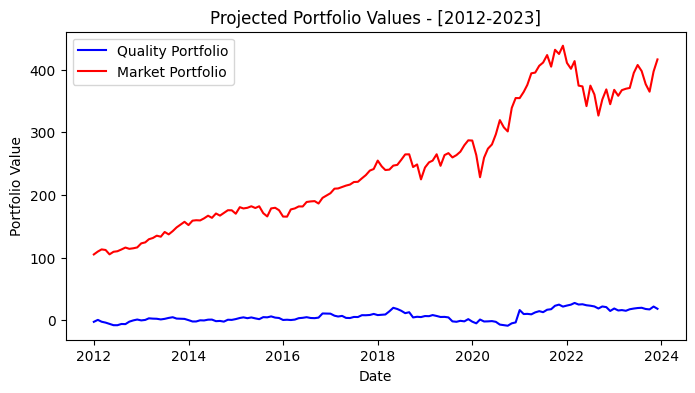

In [125]:
cumulative_returns1 = (1 + Quality_FF['H-L']['2012':]).cumprod()
cumulative_returns2 = (1 + Quality_FF['mktrf']['2012':]).cumprod() 

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [2012-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### 2.1.5 Regressions

**1) CAPM**

In [95]:
factors_CAPM = Quality_FF['mktrf']

regression_results_CAPM = pd.DataFrame(index=portfolio_df.columns, columns=['Alpha CAPM', 'Mkt-RF'])

for portfolio in portfolio_df.columns:
    portfolio_returns = portfolio_df[portfolio]
    
    X_CAPM = sm.add_constant(factors_CAPM)
    X_CAPM = X_CAPM
    
    model = sm.OLS(portfolio_returns, X_CAPM)
    results = model.fit()
    
    regression_results_CAPM.loc[portfolio, 'Alpha CAPM'] = results.params[0] 
    regression_results_CAPM.loc[portfolio, 'Mkt-RF'] = results.params[1]

regression_results_CAPM = regression_results_CAPM.T
regression_results_CAPM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,0.008514,0.006821,0.008014,0.004087,0.006536,0.008551,0.007019,0.009221,0.007355,0.006402,-0.004264
Mkt-RF,0.946231,0.953663,0.907018,0.914553,0.96818,0.954982,0.991554,1.091272,1.165758,1.149654,0.205389


**2) FF-3**

In [96]:
factors_FF3 = Quality_FF[['mktrf', 'smb', 'hml']]

regression_results_FF3 = pd.DataFrame(index=portfolio_df.columns, columns=['Alpha FF3', 'Mkt-RF'])

for portfolio in portfolio_df.columns:
    portfolio_returns = portfolio_df[portfolio]
    
    X_FF3 = sm.add_constant(factors_FF3)
    
    model = sm.OLS(portfolio_returns, X_FF3)
    results = model.fit()
    
    regression_results_FF3.loc[portfolio, 'Alpha FF3'] = results.params[0] 
    regression_results_FF3.loc[portfolio, 'Mkt-RF'] = results.params[1]

regression_results_FF3 = regression_results_FF3.T
regression_results_FF3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,0.008768,0.007206,0.00824,0.00416,0.006709,0.008483,0.006718,0.009214,0.007395,0.00642,-0.004499
Mkt-RF,0.936928,0.954575,0.911697,0.915544,0.959306,0.949997,0.976685,1.051317,1.098112,1.125836,0.190171


**3) FF-5**

In [97]:
factors_FF5 = Quality_FF[['mktrf', 'smb', 'hml', 'rmw', 'cma']]

regression_results_FF5 = pd.DataFrame(index=portfolio_df.columns, columns=['Alpha FF5', 'Mkt-RF'])

for portfolio in portfolio_df.columns:
    portfolio_returns = portfolio_df[portfolio]
    
    X_FF5 = sm.add_constant(factors_FF5)
    
    model = sm.OLS(portfolio_returns, X_FF5)
    results = model.fit()
    
    regression_results_FF5.loc[portfolio, 'Alpha FF5'] = results.params[0] 
    regression_results_FF5.loc[portfolio, 'Mkt-RF'] = results.params[1]

regression_results_FF5 = regression_results_FF5.T
regression_results_FF5

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.008219,0.006982,0.007527,0.003381,0.006261,0.007273,0.006145,0.008587,0.00856,0.006924,-0.003458
Mkt-RF,0.952181,0.944958,0.92082,0.949089,0.98919,1.008837,1.016837,1.087895,1.08701,1.132889,0.182558


In [98]:
def run_regression(portfolio_df, factors_dict):
 
    regression_results = pd.DataFrame(index=['CAPM alpha', 't-stat CAPM alpha',
                                             'FF3 Alpha', 't-stat FF3 Alpha',
                                             'FF5 Alpha', 't-stat FF5 Alpha',
                                             'Adj R2'])

    for factor_name, factors_df in factors_dict.items():
        factor_results = []

        for portfolio in portfolio_df.columns:
            portfolio_returns = portfolio_df[portfolio]

            X = sm.add_constant(factors_df)

            model = sm.OLS(portfolio_returns, X)
            results = model.fit()

            alpha = results.params[0]
            t_stat_alpha = results.tvalues[0]
            adj_r2 = results.rsquared_adj
            
            factor_results.extend([alpha, t_stat_alpha,adj_r2])

    return regression_results

factors_dict = {
    'CAPM': Quality_FF[['mktrf']],
    'FF3': Quality_FF[['mktrf', 'smb', 'hml']],
    'FF5': Quality_FF[['mktrf', 'smb', 'hml', 'rmw', 'cma']]
}

regression_results = run_regression(portfolio_df, factors_dict)
regression_results

""
CAPM alpha
t-stat CAPM alpha
FF3 Alpha
t-stat FF3 Alpha
FF5 Alpha
t-stat FF5 Alpha
Adj R2


## 2.2 - Momentum Strategy

In [183]:
stk_data

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year
0,10001,1990-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.93750,-0.018519,1022.0,-0.070114,1.015612e+04,1990
1,10001,1990-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,-0.006289,1022.0,0.014900,1.009225e+04,1990
2,10001,1990-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.012658,1027.0,0.024148,1.014162e+04,1990
3,10001,1990-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.000000,1027.0,-0.028283,1.014162e+04,1990
4,10001,1990-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.75000,-0.012658,1027.0,0.088935,1.001325e+04,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
3150178,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023
3150179,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023
3150180,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023
3150181,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023


First of all we drop observations without returns data:

In [184]:
stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')
stk_data = stk_data.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

In [185]:
Momentum_df = stk_data
Momentum_df['date'] = pd.to_datetime(Momentum_df['date'], format='%Y-%m-%d')


In [186]:
Momentum_df = preprocess_dataframe(Momentum_df)

### 2.2.1 Building "Momentum Score"

In [187]:
Momentum_df = Momentum_df.sort_values(by=['PERMNO', 'date'])

window_size = 12

Momentum_df['PRC_7M'] = Momentum_df.groupby('PERMNO')['PRC'].shift(window_size - 5)  # Price at 7 months prior
Momentum_df['PRC_12M'] = Momentum_df.groupby('PERMNO')['PRC'].shift(window_size)  # Price at 12 months prior

Momentum_df['MOM12-7(HP)'] = (Momentum_df['PRC_7M'] - Momentum_df['PRC_12M']) / Momentum_df['PRC_12M']

Momentum_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(HP)
0,10001,1990-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.93750,-0.018519,1022.0,-0.070114,1.015612e+04,1990,NaN,NaN,NaN
1,10001,1990-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,-0.006289,1022.0,0.014900,1.009225e+04,1990,NaN,NaN,NaN
2,10001,1990-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.012658,1027.0,0.024148,1.014162e+04,1990,NaN,NaN,NaN
3,10001,1990-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.000000,1027.0,-0.028283,1.014162e+04,1990,NaN,NaN,NaN
4,10001,1990-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.75000,-0.012658,1027.0,0.088935,1.001325e+04,1990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150178,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023,173.22000,275.60999,-0.371503
3150179,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023,205.71001,265.25000,-0.224467
3150180,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023,207.46001,227.53999,-0.088248
3150181,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023,164.31000,194.70000,-0.156086


In [188]:
Momentum_df =Momentum_df.sort_values(by=['PERMNO', 'date'])

def compute_rolling_sum(group):
    group['MOM12-7(CUM)'] = group['RET'].shift(7).rolling(window=6).sum()
    return group

Momentum_df = Momentum_df.groupby('PERMNO').apply(compute_rolling_sum)

Momentum_df

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_6834/616378836.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Momentum_df = Momentum_df.groupby('PERMNO').apply(compute_rolling_sum)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(HP),MOM12-7(CUM)
0,10001,1990-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.93750,-0.018519,1022.0,-0.070114,1.015612e+04,1990,NaN,NaN,NaN,NaN
1,10001,1990-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,-0.006289,1022.0,0.014900,1.009225e+04,1990,NaN,NaN,NaN,NaN
2,10001,1990-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.012658,1027.0,0.024148,1.014162e+04,1990,NaN,NaN,NaN,NaN
3,10001,1990-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.87500,0.000000,1027.0,-0.028283,1.014162e+04,1990,NaN,NaN,NaN,NaN
4,10001,1990-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,9.75000,-0.012658,1027.0,0.088935,1.001325e+04,1990,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150178,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023,173.22000,275.60999,-0.371503,-0.357671
3150179,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023,205.71001,265.25000,-0.224467,-0.097617
3150180,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023,207.46001,227.53999,-0.088248,-0.051521
3150181,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023,164.31000,194.70000,-0.156086,-0.117345


### 2.2.2 Momentum Deciles Sorting

In [189]:
Momentum_df = Momentum_df.sort_values(by='MOM12-7(CUM)', ascending=False)
Momentum_df.dropna(subset=['MOM12-7(CUM)'], inplace=True)
Momentum_df['decile_Q'] = Momentum_df.groupby(['date'])['MOM12-7(CUM)'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
Momentum_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(HP),MOM12-7(CUM),decile_Q
1118438,58748,1992-08-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.68750,0.047619,16297.0,-0.020819,11204.1875,1992,1.17188,0.04688,23.997440,24.000000,10
1118439,58748,1992-09-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.53125,-0.227273,16822.0,0.012461,8936.6875,1992,1.14063,0.04688,23.330845,23.973333,10
1118440,58748,1992-10-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.50000,-0.058824,16822.0,0.010983,8411.0000,1992,0.79688,0.04688,15.998294,23.671963,10
1118441,58748,1992-11-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.75000,0.500000,16822.0,0.040181,12616.5000,1992,0.78125,0.04688,15.664889,23.652355,10
1118442,58748,1992-12-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.50000,-0.333333,17755.0,0.017740,8877.5000,1992,0.71875,0.04688,14.331698,23.572355,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245402,84521,2007-12-01,11.0,2.0,2836.0,CARDIUM THERAPEUTICS INC,2.60000,-0.018868,40935.0,-0.004405,106431.0000,2007,0.03125,4.59375,-0.993197,-3.116634,1
2647392,89169,2020-09-01,11.0,3.0,3841.0,DELCATH SYSTEMS INC,11.61000,-0.024370,4036.0,-0.035056,46857.9600,2020,0.02110,0.92000,-0.977065,-3.118186,1
3069634,92687,2017-09-01,11.0,3.0,8711.0,REAL GOODS SOLAR INC,0.87000,0.108280,7481.0,0.023729,6508.4700,2017,1.68000,3.81000,-0.559055,-3.276644,1
3056790,92571,2020-06-01,11.0,2.0,1311.0,CAMBER ENERGY INC,1.19000,-0.070312,12456.0,0.025299,14822.6400,2020,0.85610,0.15130,4.658295,-3.414555,1


### 2.2.3 Momentum Deciles Portfolios Returns

In [190]:
portfolio_mom = compute_deciles_port(Momentum_df)
portfolio_mom['H-L'] = portfolio_mom['P10'] - portfolio_mom['P1']
portfolio_mom.index = pd.to_datetime(portfolio_mom.index, format="%Y-%m-%d").to_period('M')
portfolio_mom

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
1991-01,0.156194,0.081089,0.086710,0.027040,0.025464,0.056100,0.054059,0.065386,0.102678,0.195748,0.039554
1991-02,0.220943,0.191617,0.080346,0.076865,0.077354,0.056866,0.074957,0.098613,0.081139,0.138237,-0.082706
1991-03,0.097823,0.054058,0.046913,0.030178,0.042073,0.031608,0.009101,0.040236,0.044108,0.094116,-0.003707
1991-04,0.036094,0.023132,0.037877,0.042669,0.009813,-0.004733,0.016119,0.001001,-0.002329,-0.007287,-0.043381
1991-05,0.038853,0.076550,0.090176,0.054736,0.080630,0.066250,0.070399,0.030259,0.021748,0.037130,-0.001723
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.029304,-0.009949,-0.025613,-0.028455,-0.029694,-0.000218,-0.007193,-0.004659,-0.005593,-0.019768,0.009537
2023-09,-0.077207,-0.066241,-0.037485,-0.048601,-0.039308,-0.032532,-0.044476,-0.033402,-0.046614,-0.094457,-0.017251
2023-10,-0.135519,-0.068620,-0.043442,-0.026599,-0.003804,-0.023823,-0.022953,-0.000559,-0.027692,-0.045598,0.089921


In [192]:
portfolio_mom = portfolio_mom.sub(rf, axis=0)

Momentum_FF = pd.concat([portfolio_mom, FF_data], axis=1)
Momentum_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.038304,-0.018949,-0.034613,-0.037455,-0.038694,-0.009218,-0.016193,-0.013659,-0.014593,-0.028768,0.000537,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.085807,-0.074841,-0.046085,-0.057201,-0.047908,-0.041132,-0.053076,-0.042002,-0.055214,-0.103057,-0.025851,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.144919,-0.078020,-0.052842,-0.035999,-0.013204,-0.033223,-0.032353,-0.009959,-0.037092,-0.054998,0.080521,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


### 2.2.4 Return Analysis

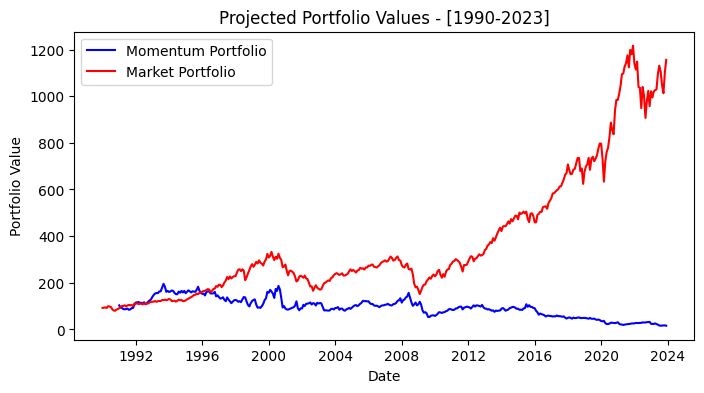

In [201]:
cumulative_returns1 = (1 + Momentum_FF['H-L']).cumprod() 
cumulative_returns2 = (1 + Momentum_FF['mktrf']).cumprod() 

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Momentum Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [1990-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### 2.2.5 Momentum Regression Results